## Agentic RAG with workflow to rewrite the prompt to get better results

In [173]:
from langchain_community.document_loaders import WebBaseLoader  
from langchain_community.vectorstores import FAISS
from langchain_ollama import ChatOllama
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import Tool, tool, StructuredTool
from langchain.agents import create_agent

In [174]:
urls = [
    "https://docs.langchain.com/oss/python/langgraph/overview",
    "https://docs.langchain.com/oss/python/langgraph/workflows-agents",
    "https://docs.langchain.com/oss/python/langgraph/graph-api#map-reduce-and-the-send-api"
]

# Load the Docs
docs = [WebBaseLoader(url).load() for url in urls]

In [175]:
# text Splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, 
    chunk_overlap=50,
    separators=[".", ","],
    keep_separator=True
)
docs_list = [doc for sublist in docs for doc in sublist]
split_docs = text_splitter.split_documents(docs_list)


In [176]:
# Embeddings
embeddings = HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")

# Vectorstore
vectorstore = FAISS.from_documents(documents=split_docs, embedding=embeddings)

# Retriever
retriever = vectorstore.as_retriever(search_kwargs={'k': 5})

In [177]:
### Retriever to retriever tools

def create_retriever_tool(query):
    """Use this tool to retrieve relevant documents"""
    print("Calling retriever tool")
    result = retriever.invoke(query)
    return "\n\n".join([docs.page_content for docs in result])


retriever_tool = Tool(
    name="Retriever_Tool",
    description="Use this tool to retrieve relevant documents",
    func=create_retriever_tool
)

retriever_tool

Tool(name='Retriever_Tool', description='Use this tool to retrieve relevant documents', func=<function create_retriever_tool at 0x7327f1abee80>)

## Langchain - Seperate Vectorstore

In [178]:
langchain_urls = [
    "https://docs.langchain.com/oss/python/langchain/rag",
    "https://docs.langchain.com/oss/python/langchain/knowledge-base",
    "https://docs.langchain.com/oss/python/langgraph/sql-agent"
]


docs = [WebBaseLoader(url).load() for url in langchain_urls]
docs

[[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langchain/rag', 'title': 'Build a RAG agent with LangChain - Docs by LangChain', 'language': 'en'}, page_content='Build a RAG agent with LangChain - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...⌘KGitHubTry LangSmithTry LangSmithSearch...NavigationLangChainBuild a RAG agent with LangChainLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonLearnTutorialsLangChainSemantic searchRAG agentSQL agentSupervisor agentLangGraphConceptual overviewsMemoryContextGraph APIFunctional APIAdditional resourcesLangChain AcademyCase studiesOn this pageOverviewConceptsPreviewSetupInstallationLangSmithComponents1. IndexingLoading documentsSplitting documentsStoring documents2. Retrieval and GenerationRAG agentsRAG chainsNext stepsTutorialsLangChainBuild a RAG agent with LangChainCopy pageCopy page\u200bOverview\nOne of the most powerful applications enabled by LLMs is sop

In [179]:
# text Splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, 
    chunk_overlap=50,
    separators=[".", ","],
    keep_separator=True
)
docs_list = [doc for sublist in docs for doc in sublist]
split_docs = text_splitter.split_documents(docs_list)

# Embeddings
embeddings = HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")

# Vectorstore
vectorstore_langchain = FAISS.from_documents(documents=split_docs, embedding=embeddings)

# Retriever
retriever_langchain = vectorstore.as_retriever(search_kwargs={'k': 5})

In [180]:
### Retriever to retriever tools
from typing import TypedDict, List

class RetrievedDoc(TypedDict):
    content: str
    source: str
    score: float | None


def create_langchain_retriever_tool(query:str) -> List[RetrievedDoc]:
    """Use this tool to retrieve relevant documents"""
    print("Calling retriever tool")
    result = retriever.invoke(query)
    return [
        {
            "content": d.page_content,
            "source": d.metadata.get("source"),
            "score": d.metadata.get("score")
        } 
        for d in result
    ]


langchain_retriever_tool = StructuredTool.from_function(
    name="Langchain_Retriever_Tool",
    description="Use this tool to retrieve relevant documents",
    func=create_retriever_tool
)

langchain_retriever_tool

StructuredTool(name='Langchain_Retriever_Tool', description='Use this tool to retrieve relevant documents', args_schema=<class 'langchain_core.utils.pydantic.Langchain_Retriever_Tool'>, func=<function create_retriever_tool at 0x7327f1abee80>)

In [181]:
tools = [ retriever_tool, langchain_retriever_tool]

### LangGraph Workflow

In [182]:
from typing import Annotated, Sequence, TypedDict, Literal
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_classic import hub
from langchain_core.messages import BaseMessage, HumanMessage

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says, "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [183]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")

In [184]:
def agent(state: AgentState) -> AgentState:
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retreiver tool, or simply end.
    
    Args:
        state(messages): The current state
    
    Returns:
        dict: The updated state with the agent response appended to messages
    """
    
    print("-- CALL AGENT ---")
    messages = state["messages"]
    model = ChatGroq(model="qwen/qwen3-32b")
    llm_with_tools = model.bind_tools(tools)
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [185]:
# Edge
def grade_documents(state: AgentState) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.
    
    Args:
        state (messages): The current state
        
    Returns:
        str: A decision for wheter the documents are relevant or not
    """
    
    print("--- CHECK RELEVANCE ---")
    
    # Data Model
    class grade(BaseModel):
        """Binary score for relevance check"""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
    
    # LLM 
    model = ChatGroq(model="qwen/qwen3-32b")
    
    # LLM with tools
    llm_with_tool = model.with_structured_output(grade)
    
    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a grader assessing relevance of a retrieved document to a user question.\n
            Here is the retrieved document: \n\n {context} \n\n
            Here is the user question: {question} \n
            If the document containes keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
            Give a binary score 'yes' or 'no' score to indicate wheter the document is relevant tto the question.
        """,
        input_variables=["context", "question"]
    )
    
    # Chain
    chain = prompt | llm_with_tool
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # First message -> Question
    question = messages[0].content
    
    # Last message -> retrieved document
    docs = last_message
    
    scored_result = chain.invoke({'question': question, "context": docs})
    score = scored_result.binary_score
    
    if score == "yes":
        print("---DECISION: DOCS RELEVANT TO QUESTION---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"  

In [186]:
def generate(state: AgentState) -> AgentState:
    """ 
    Generate Answer
    
    Args:
        state (messages): The current state
        
    Returns:
        state (messages): The updated state
    """
    
    print("---GENERATE ANSWER---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    
    docs = last_message.content
    
    # Prompt for answer generation
    prompt = hub.pull("rlm/rag-prompt")
    
    # LLM
    llm = ChatGroq(model="qwen/qwen3-32b")
    
    # Post processing
    def format_docs(docs):
        return "\n\n".join([doc.page_content for doc in docs])
    
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    
    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    
    return {"messages": [response]}

In [187]:
def rewrite(state: AgentState) -> AgentState:
    """ 
    Transform the query to produce a better question.
    
    Args:
        state (messages): The current state

    Returns:
       messages (list): The updateddicst: The updated state with re-phrased question
    """
    
    print("---TRANSFORM QUERY---")
    messages = state['messages']
    question = messages[0].content
    
    msg = [
        HumanMessage(content=f"""
                Look a the input and try to reason about the underlying semantic intent / meaning.\n
                Here is the initial question:
                \n-----\n 
                {question}
                \n-----\n 
                Formulate an improved question: 
            """
        )
    ]
    
    # Grader
    llm = ChatGroq(model="qwen/qwen3-32b")
    response = llm.invoke(msg)
    return {"messages": [response]}    

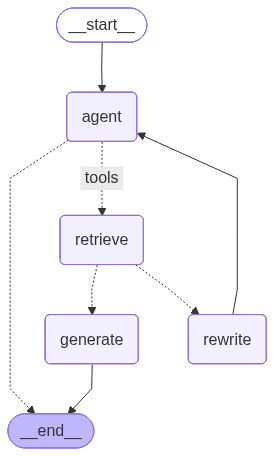

In [188]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image

# define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)
retrieve = ToolNode([langchain_retriever_tool, retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate) 

# Edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END
    }        
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,    
)

workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [192]:
result = graph.invoke({"messages":[HumanMessage(content="What ist langgraph?")]})
print(result['messages'][-1].content)

-- CALL AGENT ---
Calling retriever tool
--- CHECK RELEVANCE ---
---DECISION: DOCS RELEVANT TO QUESTION---
---GENERATE ANSWER---
<think>
Okay, the user is asking "What ist langgraph?" which seems like a typo for "What is LangGraph?" First, I need to check the provided context.

Looking through the context, there's a mention that LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents. It's part of LangChain and is used for agent orchestration. Also, it's inspired by Pregel and Apache Beam, and it has built-in visualization tools. The context also notes that it's used by companies like Klarna and Replit.

I need to make sure I capture the main points: it's a framework for agents, part of LangChain, low-level, and has some inspirations from other systems. The user might be looking for a concise definition and key features. Since the answer should be three sentences max, I'll summarize the purpose, key features, and 